In [1]:
I = 21
r = [10, 23, 23, 26, 17, 5, 53, 55, 32, 46, 10, 8, 10, 8, 23, 0,3, 22, 15, 32, 3]
N =[39, 62, 81, 51, 39, 6, 74, 72, 51, 79, 13, 16, 30, 28, 45, 4, 12, 41, 30, 51, 7]
x1=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
x2=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [2]:
import numpy as np
from tqdm import tqdm
##GIBBS
#Entrée
nChain = 10000
alpha = np.zeros((nChain,4))
acceptAlpha = np.zeros(4)

betas = np.zeros((nChain,I))
acceptBeta = np.zeros(I)

tau = np.ones(nChain)
acceptTau = 0
for i in tqdm(range(1,nChain)):
  alpha[i] = alpha[i-1]

  #PROP ALPHA
  for a in range(4):
    alphaProp = alpha[i].copy()
    alphaProp[a] += np.random.normal(scale=0.1)
    logTop = 0
    logBottom = 0
    for j in range(I):
      X = np.array([1,x1[j],x2[j],x2[j]*x1[j]])

      pjProp =  1/(1+np.exp(-np.dot(X,alphaProp)-betas[i-1,j]))
      pj =  1/(1+np.exp(-np.dot(X,alpha[i])-betas[i-1,j]))
      logTop += r[j]*np.log(pjProp)+(N[j]-r[j])*np.log(1-pjProp)
      logBottom += r[j]*np.log(pj)+(N[j]-r[j])*np.log(1-pj)
    A = np.exp(logTop-logBottom)
    if np.random.uniform() <= A:
      alpha[i] = alphaProp.copy()
      acceptAlpha[a]+=1
  
  #PROP BETA
  betas[i]= betas[i-1]
  for j in range(I):
    X = np.array([1,x1[j],x2[j],x2[j]*x1[j]])
    betaProp = betas[i-1,j] + np.random.normal(scale=1)

    pjProp =  1/(1+np.exp(-np.dot(X,alpha[i])-betaProp))
    pj =  1/(1+np.exp(-np.dot(X,alpha[i])-betas[i-1,j]))

    logTop = r[j]*np.log(pjProp)+(N[j]-r[j])*np.log(1-pjProp)
    logBottom = r[j]*np.log(pj)+(N[j]-r[j])*np.log(1-pj)

    A = np.exp(logTop-logBottom)
    if np.random.uniform() <= A:
      betas[i,j] = betaProp
      acceptBeta[j] += 1

  #PROP TAU
  tauProp = tau[i-1]*np.exp(np.random.normal(scale=1))

  logTop = -tauProp/2 * (betas[i,:]**2).sum() + np.log(tauProp)
  logBottom = -tau[i-1]/2 * (betas[i,:]**2).sum() + np.log(tau[i-1])

  A = np.exp(logTop-logBottom)#loi a priori = 1
  if np.random.uniform() <= A:
        tau[i] = tauProp
        acceptTau += 1
  else:
    tau[i] = tau[i-1]

acceptAlpha = acceptAlpha/nChain
acceptBeta = acceptBeta/nChain
acceptTau = acceptTau/nChain

100%|█████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:23<00:00, 423.89it/s]


In [25]:
from tqdm import tqdm
##GIBBS loi gamma sur tau
#Entrée
nChain = 50000
alpha = np.zeros((nChain,4))
acceptAlpha = np.zeros(4)

betas = np.zeros((nChain,I))
acceptBeta = np.zeros(I)

tau = np.ones(nChain)
acceptTau = 0
for i in tqdm(range(1,nChain)):
  alpha[i] = alpha[i-1]

  #PROP ALPHA
  for a in range(4):
    alphaProp = alpha[i].copy()
    alphaProp[a] += np.random.normal(scale=0.1)
    logTop = -1/2 * alphaProp[a]**2/ 10**6
    logBottom = -1/2 * alpha[i,a]**2/ 10**6
    for j in range(I):
      X = np.array([1,x1[j],x2[j],x2[j]*x1[j]])

      pjProp =  1/(1+np.exp(-np.dot(X,alphaProp)-betas[i-1,j]))
      pj =  1/(1+np.exp(-np.dot(X,alpha[i])-betas[i-1,j]))
      logTop += r[j]*np.log(pjProp)+(N[j]-r[j])*np.log(1-pjProp)
      logBottom += r[j]*np.log(pj)+(N[j]-r[j])*np.log(1-pj)
    A = np.exp(logTop-logBottom)
    if np.random.uniform() <= A:
      alpha[i] = alphaProp.copy()
      acceptAlpha[a]+=1
  
  #PROP BETA
  betas[i]= betas[i-1]
  for j in range(I):
    X = np.array([1,x1[j],x2[j],x2[j]*x1[j]])
    betaProp = betas[i-1,j] + np.random.normal(scale=1)

    pjProp =  1/(1+np.exp(-np.dot(X,alpha[i])-betaProp))
    pj =  1/(1+np.exp(-np.dot(X,alpha[i])-betas[i-1,j]))

    logTop = -1/2 * betaProp**2 * tau[i] + r[j]*np.log(pjProp)+(N[j]-r[j])*np.log(1-pjProp)
    logBottom = -1/2 * betas[i,j]**2 * tau[i] + r[j]*np.log(pj)+(N[j]-r[j])*np.log(1-pj)

    A = np.exp(logTop-logBottom)
    if np.random.uniform() <= A:
      betas[i,j] = betaProp
      acceptBeta[j] += 1

  #PROP TAU
  
  k=0.001+I/2
  beta=10**-3+(betas[i,:]**2).sum()/2
  tauProp = np.random.gamma(shape=k,scale=1/beta)

#   logTop = -1.5*np.log(tauProp) - tauProp/2 * (betas[i,:]**2).sum()  + 21/2 * np.log(tauProp) + np.log(tauProp)
#   logBottom = -1.5*np.log(tau[i-1]) - tau[i-1]/2 * (betas[i,:]**2).sum()  + 21/2 * np.log(tau[i-1]) + np.log(tau[i-1])

#   A = np.exp(logTop-logBottom)
#   if np.random.uniform() <= A:
#         tau[i] = tauProp
#         acceptTau += 1
#   else:
  tau[i] = tauProp#tau[i-1]

acceptAlpha = acceptAlpha/nChain
acceptBeta = acceptBeta/nChain
acceptTau = acceptTau/nChain

100%|███████████████████████████████████████████████████████████████████████████| 49999/49999 [02:05<00:00, 399.77it/s]


In [26]:
alpha.mean(axis=0)

array([-0.58380311, -0.04829096,  1.5233294 , -0.97417045])

Taux d'acceptation alpha 0 = 0.62044
alpha0 = -0.5838031114467293


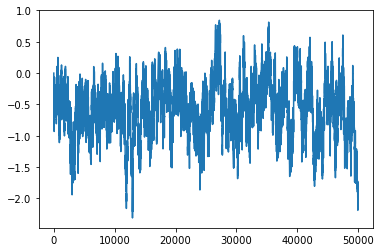

Taux d'acceptation alpha 1 = 0.7605
alpha1 = -0.048290960905196044


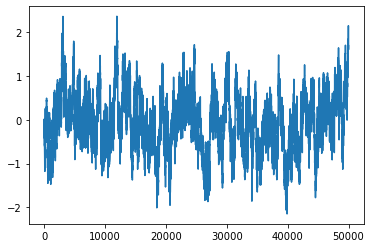

Taux d'acceptation alpha 2 = 0.71152
alpha2 = 1.5233294039372307


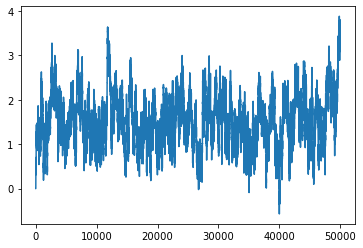

Taux d'acceptation alpha 3 = 0.8188
alpha3 = -0.9741704473367927


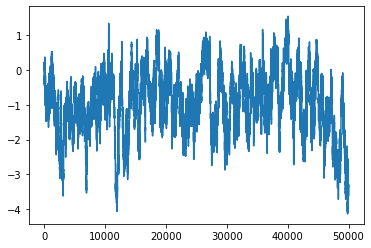

In [27]:
import matplotlib.pyplot as plt
for i in range(4):
  plt.plot(range(nChain),alpha[:,i])
  print(f"Taux d'acceptation alpha {i} = {acceptAlpha[i]}")
  print(f"alpha{i} = {alpha[:,i].mean()}")
  plt.show()

Taux d'acceptation betas 0 = 0.38032


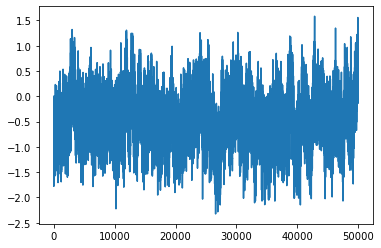

Taux d'acceptation betas 1 = 0.3008


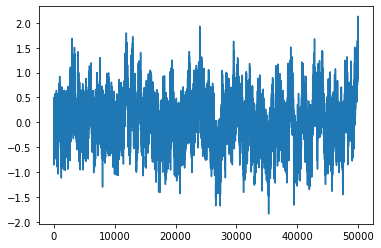

Taux d'acceptation betas 2 = 0.28206


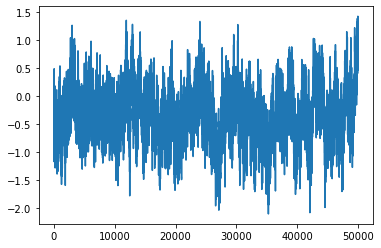

Taux d'acceptation betas 3 = 0.32078


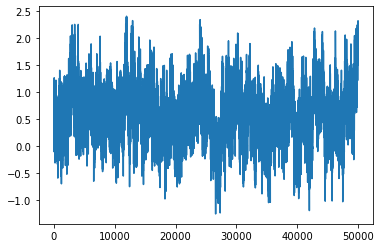

Taux d'acceptation betas 4 = 0.35232


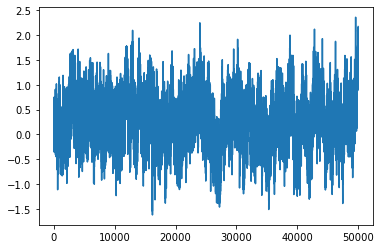

Taux d'acceptation betas 5 = 0.60834


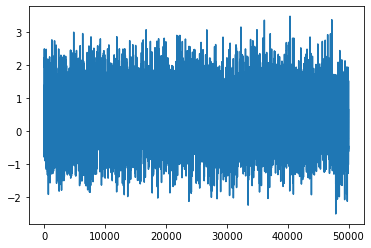

Taux d'acceptation betas 6 = 0.29834


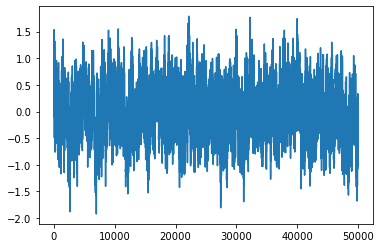

Taux d'acceptation betas 7 = 0.31426


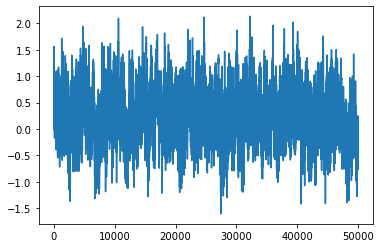

Taux d'acceptation betas 8 = 0.32802


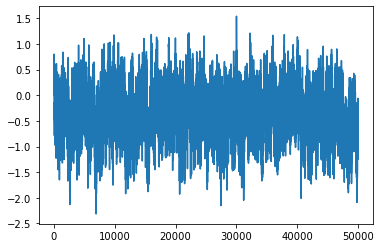

Taux d'acceptation betas 9 = 0.26448


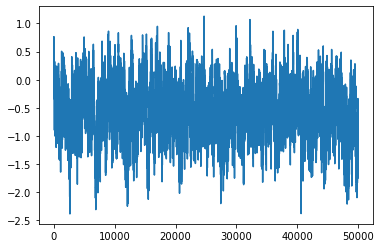

Taux d'acceptation betas 10 = 0.53076


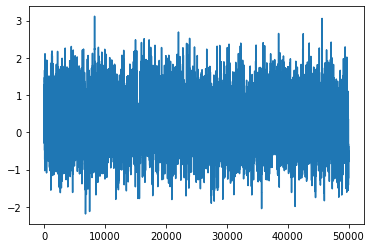

Taux d'acceptation betas 11 = 0.46958


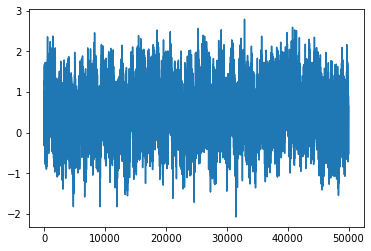

Taux d'acceptation betas 12 = 0.39942


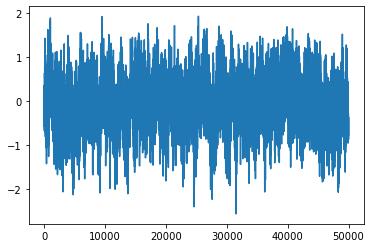

Taux d'acceptation betas 13 = 0.4215


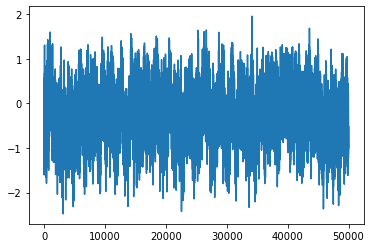

Taux d'acceptation betas 14 = 0.33102


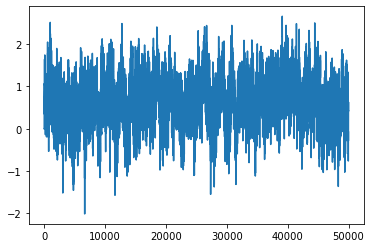

Taux d'acceptation betas 15 = 0.64152


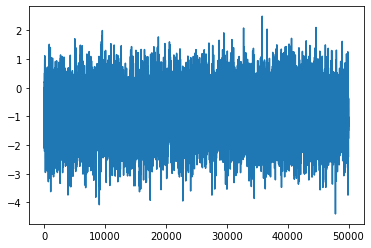

Taux d'acceptation betas 16 = 0.52322


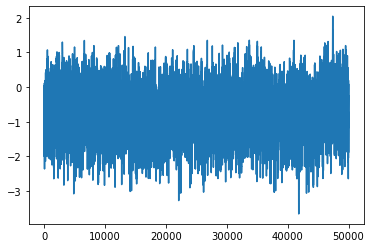

Taux d'acceptation betas 17 = 0.34488


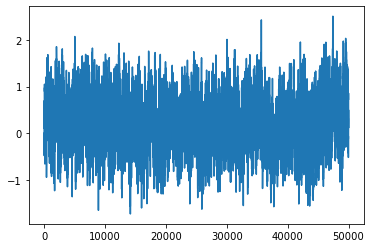

Taux d'acceptation betas 18 = 0.38334


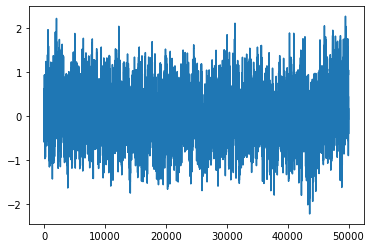

Taux d'acceptation betas 19 = 0.32806


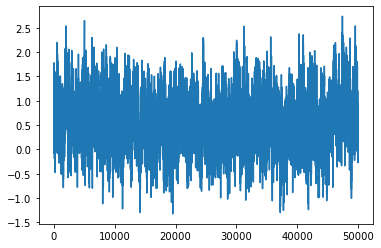

Taux d'acceptation betas 20 = 0.5674


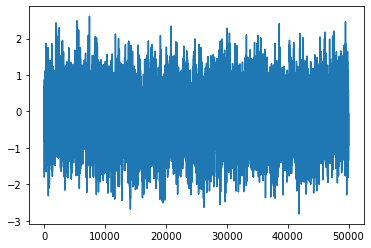

In [28]:
import matplotlib.pyplot as plt
for i in range(I):
  plt.plot(range(nChain),betas[:,i])
  print(f"Taux d'acceptation betas {i} = {acceptBeta[i]}")
  plt.show()

Taux d'acceptation tau = 0.0
Tau moyen = 2.178500526582552


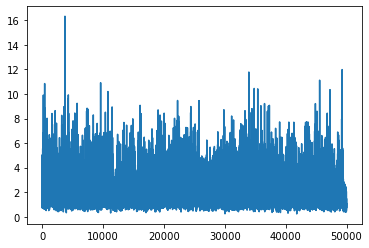

In [29]:
plt.plot(range(nChain),tau)
print(f"Taux d'acceptation tau = {acceptTau}")
print(f"Tau moyen = {tau.mean()}")

Taux d'acceptation tau = 0.0
Sigma moyen = 0.7347049885265522


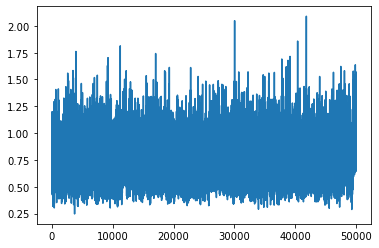

In [30]:
sigma = 1/np.sqrt(tau)
plt.plot(range(nChain),sigma)
print(f"Taux d'acceptation tau = {acceptTau}")
print(f"Sigma moyen = {sigma.mean()}")

In [25]:
import numpy as np
alpha = np.ones((4))
print(alpha)
var = alpha[0]
var = 0
alpha

[1. 1. 1. 1.]


array([1., 1., 1., 1.])

Prediction = [10.226109730185245] , réalité = [10]
Prediction = [22.78917864493017] , réalité = [23]
Prediction = [23.088945338099485] , réalité = [23]
Prediction = [25.482194550252338] , réalité = [26]
Prediction = [16.651191751327254] , réalité = [17]
Prediction = [4.741516042947959] , réalité = [5]
Prediction = [53.12511772715381] , réalité = [53]
Prediction = [55.004362120423316] , réalité = [55]
Prediction = [32.4793194119929] , réalité = [32]
Prediction = [46.598817930558994] , réalité = [46]
Prediction = [9.953624756467411] , réalité = [10]
Prediction = [7.477406678758647] , réalité = [8]
Prediction = [9.912778110414559] , réalité = [10]
Prediction = [8.075542116267153] , réalité = [8]
Prediction = [22.359054664673927] , réalité = [23]
Prediction = [0.743567720636384] , réalité = [0]
Prediction = [3.6044726502794866] , réalité = [3]
Prediction = [21.82732919549337] , réalité = [22]
Prediction = [14.93754375000733] , réalité = [15]
Prediction = [31.557685969068267] , réalité = [3

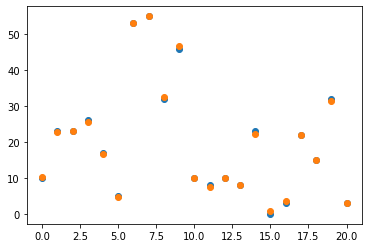

In [31]:
#pred
predAlpha = alpha.mean(axis=0)
predBeta = betas.mean(axis=0)
prediction = []
for i in range(I):
    X = np.array([1,x1[i],x2[i],x2[i]*x1[i]])
    pj =  1/(1+np.exp(-np.dot(X,predAlpha)-predBeta[i]))
#     print(X,predAlpha,np.dot(X,predAlpha))
    
    print(f"Prediction = [{pj*N[i]}] , réalité = [{r[i]}]")
    prediction.append(pj*N[i])
    
plt.scatter(range(I),r)
plt.scatter(range(I),prediction)

In [32]:
predBeta.std()

0.4298970905531169